In [1]:
import os
os.path

from datetime import datetime, timedelta
import cmocean

import pyproj
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import trajan as ta
import pandas as pd

import opendrift
from opendrift.models.leeway import Leeway
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.physics_methods import wind_drift_factor_from_trajectory, distance_between_trajectories, skillscore_liu_weissberg

import cartopy.crs as ccrs
from matplotlib.lines import Line2D

from scipy.spatial import ConvexHull, convex_hull_plot_2d

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
from matplotlib.lines import Line2D

In [2]:
reader_globcur = reader_netCDF_CF_generic.Reader("C:/Users/bente/Documents/THESIS/Globcurrent/*.nc")
reader_wind = reader_netCDF_CF_generic.Reader('C:/Users/bente/Documents/THESIS/Globcurrent/Simulations_24h/OO-2023-03/agulhas_wind_2023.nc',
        standard_name_mapping={'u10': 'x_wind',
                               'v10': 'y_wind'})

object_type = 26  # Life-raft, no ballast

In [3]:
duration = timedelta(hours=48)                # 5 days
start_time = datetime(2023,1,23,3,12,8)
end_time = start_time + duration

In [4]:
# Set the desired grid size
grid_size_lon = 0.25  # Change this to your desired grid size
grid_size_lat = 0.25

# Calculate the number of grid cells in each dimension
lon_bins = np.arange(34, 36, grid_size_lon)
lat_bins = np.arange(-38, -36, grid_size_lat)

In [5]:
binmesh = np.meshgrid(lon_bins, lat_bins)

In [6]:
lons = np.zeros((len(lon_bins)-1,(len(lat_bins)*100)-100))
lats = np.zeros((len(lon_bins)-1,(len(lat_bins)*100)-100))
for i in range(len(binmesh[0][0])-1):
    for j in range(len(binmesh[1])-1):
        lons[i][(j*100):((j+1)*100)] = np.random.uniform(binmesh[0][0][i], binmesh[0][0][i+1], 100) # Much coarser CCC
        lats[i][(j*100):((j+1)*100)] = np.random.uniform(binmesh[1][j][0], binmesh[1][j+1][0], 100)

# FWD

In [7]:
outfile = "D:/backtrack/oceandrift_48h/likelihood/lw_fwd_2325jan_raft_capsize_v3.nc"

In [ ]:
ofwd = Leeway(loglevel=0)
ofwd.add_reader([reader_globcur, reader_wind])
ofwd.set_config('drift:advection_scheme', 'runge-kutta4')

ofwd.set_config('environment:fallback:x_sea_water_velocity', 0)
ofwd.set_config('environment:fallback:y_sea_water_velocity', 0)

ofwd.set_config('capsizing', True)
ofwd.set_config('capsizing:wind_threshold', 20)
ofwd.set_config('capsizing:wind_threshold_sigma', 5)
ofwd.set_config('capsizing:leeway_fraction', 0.4)  # Reducing leeway coefficients to 40% of original after capsize

#ofwd.set_config('drift:horizontal_diffusivity', 20)
ofwd.seed_elements(lon=lons, lat=lats, radius=0, time=start_time, object_type=object_type)
ofwd.run(duration=duration, time_step=600, time_step_output=3600, outfile=outfile)

10:49:59 DEBUG   opendrift.config:161: Adding 16 config items from __init__
10:49:59 DEBUG   opendrift.config:171:   Overwriting config item readers:max_number_of_fails
10:49:59 DEBUG   opendrift.config:161: Adding 5 config items from __init__
10:49:59 INFO    opendrift.models.basemodel:533: OpenDriftSimulation initialised (version 1.11.2 / v1.11.2-43-gce9f6bb)
10:49:59 DEBUG   opendrift.config:161: Adding 6 config items from leeway
10:49:59 DEBUG   opendrift.config:171:   Overwriting config item seed:jibe_probability
10:49:59 DEBUG   opendrift.models.basemodel.environment:328: Added reader C:/Users/bente/Documents/THESIS/Globcurrent/*.nc
10:49:59 DEBUG   opendrift.models.basemodel.environment:328: Added reader C:/Users/bente/Documents/THESIS/Globcurrent/Simulations_24h/OO-2023-03/agulhas_wind_2023.nc
10:49:59 INFO    opendrift.models.leeway:309: Seeding elements of object type 26: LIFE-RAFT-NB-1 (Life-raft, no ballast (NB) system, general (mean values))
10:49:59 INFO    opendrift.mode

In [20]:
fwd = xr.open_dataset(outfile)

In [21]:
len(fwd.trajectory)

4900

In [22]:
capsized = []
for i in range(len(fwd.trajectory)):
    capsized.append(fwd.isel(trajectory=i).capsized.values[-1])

In [23]:
np.count_nonzero(capsized)

3183

10:57:34 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=True, lscale=None
10:57:34 WARNING opendrift.models.basemodel:2379: Plotting fast. This will make your plots less accurate.


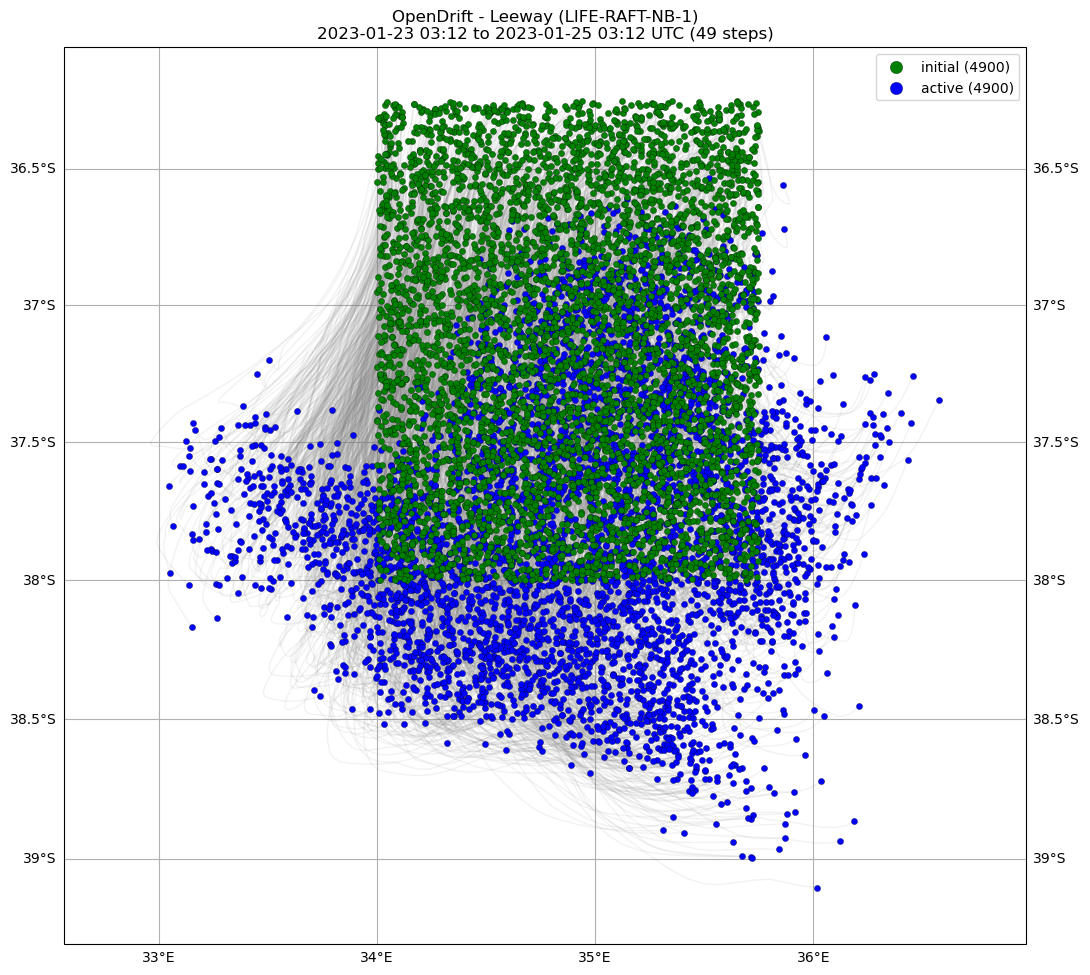

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-01-23 03:12 to 2023-01-25 03:12 UTC (49 steps)'}>,
 <Figure size 1100x1024.45 with 1 Axes>)

In [17]:
from matplotlib.colors import ListedColormap
ofwd.plot(color='capsized', cmap=ListedColormap(['black','red']), fast=True)

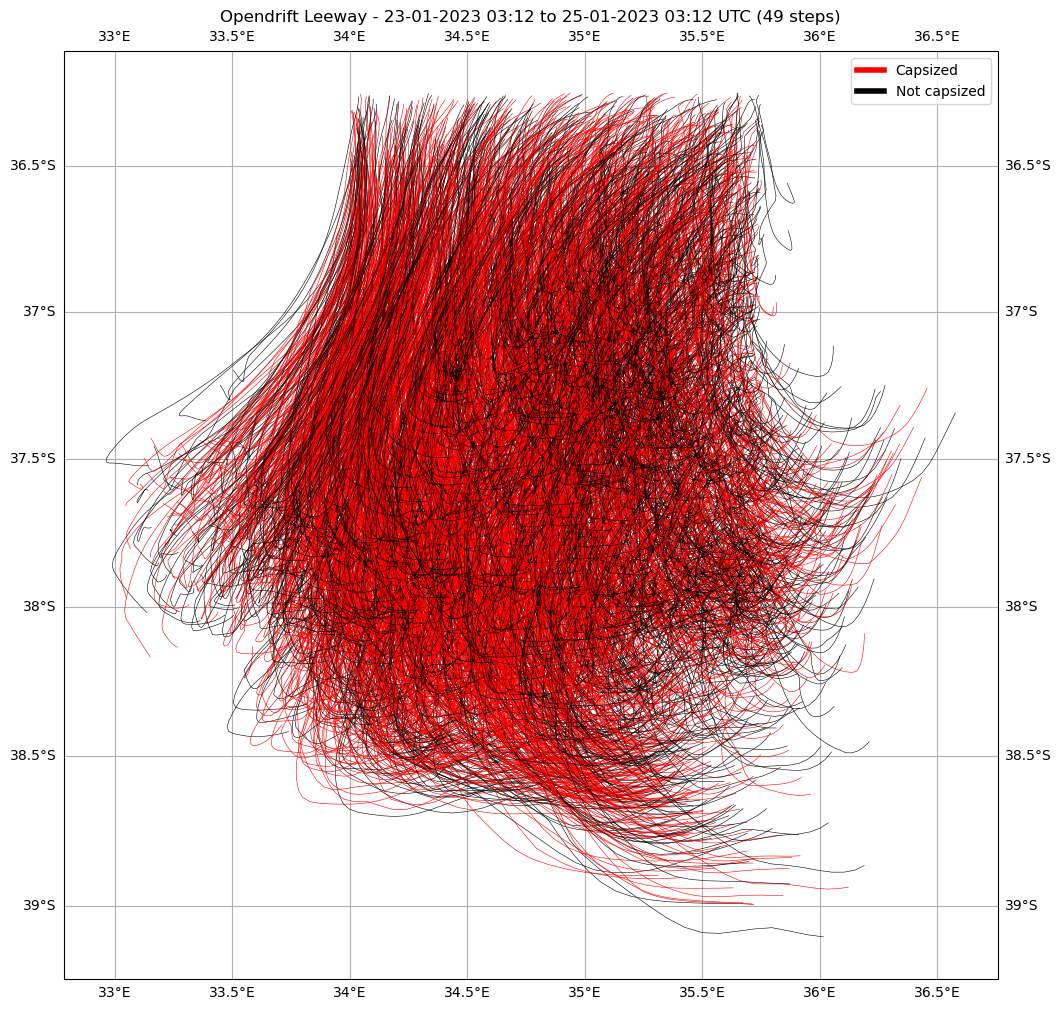

In [18]:
### PLOT ### 
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(fwd.trajectory)):
    if capsized[i]>0: 
        fwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
    else: 
        fwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='black')
    
ccrs.Geodetic()

custom_lines = [#Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                #Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4)]

ax.legend(custom_lines, ['Capsized', 'Not capsized'])

plt.gca().autoscale()
plt.title('Opendrift Leeway - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
plt.show()

In [19]:
## FORWARD ## 
lonend0 = []
latend0 = []
for j in range(len(fwd.trajectory)):
        lonend0.append(fwd.isel(trajectory=j).lon.values[-1])   # lon at end of trajectory
        latend0.append(fwd.isel(trajectory=j).lat.values[-1])   # lat at end of trajectory

## BACKWARDS

In [103]:
# orev = Leeway(loglevel=50)

13:35:17 DEBUG   opendrift.config:161: Adding 10 config items from environment
13:35:17 DEBUG   opendrift.config:161: Adding 5 config items from environment


In [108]:
# outfile_bwd = "D:/backtrack/oceandrift_48h/likelihood/lw_bwd_2325jan_raft_capsize_v2.nc"

In [109]:
# lonend1 = np.array(lonend0)
# latend1 = np.array(latend0)

In [110]:
# lonend = lonend1[~np.isnan(lonend0)]
# latend = latend1[~np.isnan(latend0)]

In [111]:
# orev = Leeway(loglevel=50)
# orev.add_reader([reader_globcur, reader_wind])

# orev.set_config('drift:advection_scheme', 'runge-kutta4')
# orev.set_config('environment:fallback:x_sea_water_velocity', 0)
# orev.set_config('environment:fallback:y_sea_water_velocity', 0)

# orev.set_config('capsizing', True)
# orev.set_config('capsizing:wind_threshold', 20)
# orev.set_config('capsizing:wind_threshold_sigma', 5)
# orev.set_config('capsizing:leeway_fraction', 0.4)  # Reducing leeway coefficients to 40% of original after capsize

# #orev.set_config('drift:horizontal_diffusivity', 20)
# orev.seed_elements(lon=lonend, lat=latend, radius_type='uniform', time=end_time, object_type=object_type, capsized=1)
# orev.run(duration=duration, time_step=-600, time_step_output=3600, outfile=outfile_bwd)

In [112]:
# bwd = xr.open_dataset(outfile_bwd)

In [113]:
# capsized_bwd = []
# for i in range(len(bwd.trajectory)):
#     capsized_bwd.append(bwd.isel(trajectory=i).capsized.values[-1])

In [114]:
# np.count_nonzero(capsized_bwd)

2493

In [115]:
# len(bwd.trajectory)

4900

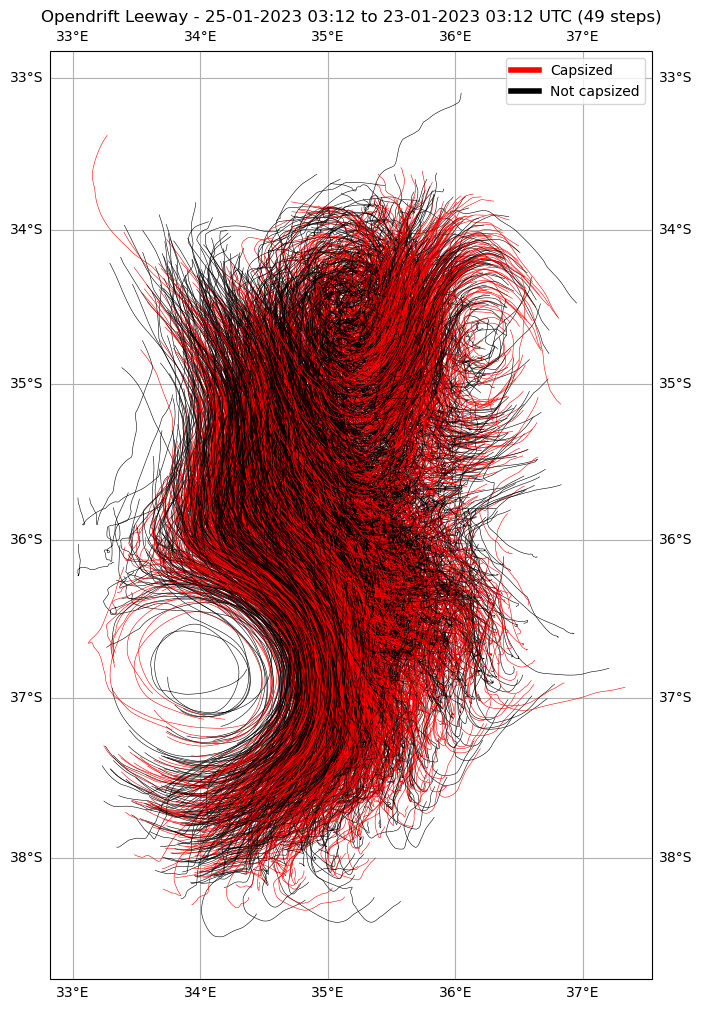

In [116]:
# ### PLOT ### 
# fig = plt.figure(figsize=(12,10))
# ax = fig.add_subplot(projection=ccrs.Mercator())
# ax.gridlines(draw_labels=True)

# for i in range(len(bwd.trajectory)):
#     if capsized_bwd[i]>0: 
#         bwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
#     else: 
#         bwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='black')
    
# ccrs.Geodetic()

# custom_lines = [#Line2D([0], [0], color='blue', lw=4),
#                 Line2D([0], [0], color='red', lw=4),
#                 #Line2D([0], [0], color='grey', lw=4),
#                 Line2D([0], [0], color='black', lw=4)]

# ax.legend(custom_lines, ['Capsized', 'Not capsized'])

# plt.gca().autoscale()
# plt.title('Opendrift Leeway - 25-01-2023 03:12 to 23-01-2023 03:12 UTC (49 steps)')
# plt.show()

## Comparison

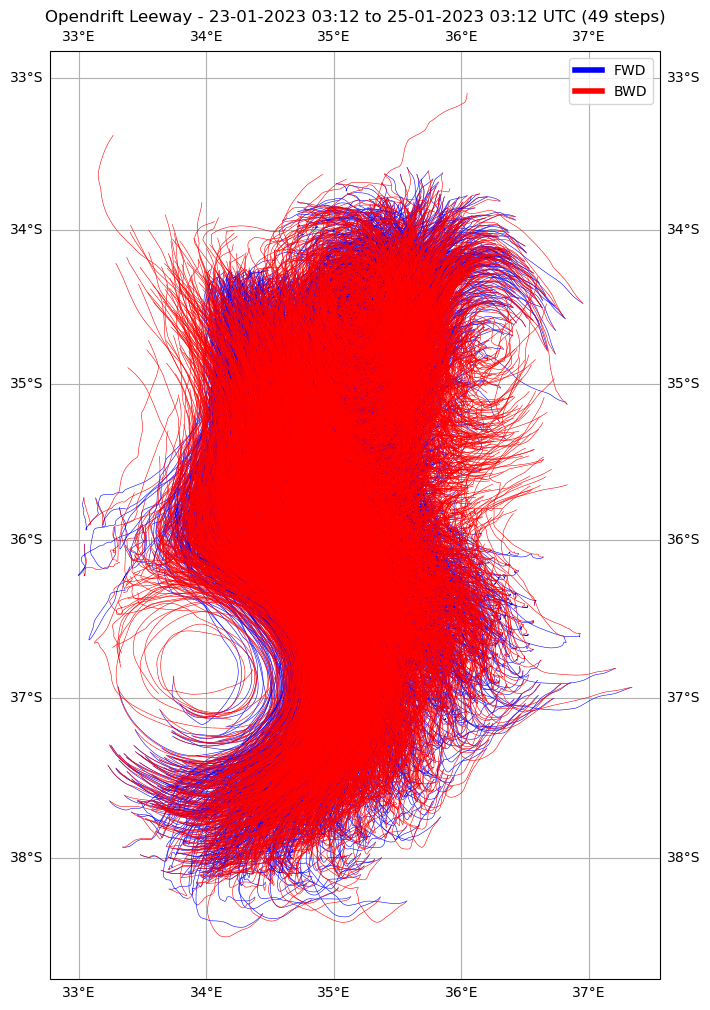

In [117]:
### PLOT ### 
# fig = plt.figure(figsize=(12,10))
# ax = fig.add_subplot(projection=ccrs.Mercator())
# ax.gridlines(draw_labels=True)

# for i in range(len(fwd.trajectory)):
#     fwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')

# for i in range(len(bwd.trajectory)):
#     bwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
    
# ccrs.Geodetic()

# custom_lines = [Line2D([0], [0], color='blue', lw=4),
#                 Line2D([0], [0], color='red', lw=4),
#                 #Line2D([0], [0], color='grey', lw=4),
#                 #Line2D([0], [0], color='black', lw=4)
#                ]

# ax.legend(custom_lines, ['FWD', 'BWD'])

# plt.gca().autoscale()
# plt.title('Opendrift Leeway - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
# plt.show()

In [118]:
# ### PLOT ### 
# fig = plt.figure(figsize=(12,10))
# ax = fig.add_subplot(projection=ccrs.Mercator())
# ax.gridlines(draw_labels=True)

# for i in range(len(fwd.trajectory)):
#     fwd.isel(trajectory=i).isel(time=0).traj.plot(linewidth=0.4, color='blue', marker='o')
#     fwd.isel(trajectory=i).isel(time=48).traj.plot(linewidth=0.4, color='lightblue', marker='o')

# for i in range(len(bwd.trajectory)):
#     bwd.isel(trajectory=i).isel(time=48).traj.plot(linewidth=0.4, color='red', marker='o')
#     bwd.isel(trajectory=i).isel(time=0).traj.plot(linewidth=0.4, color='pink', marker='o')
    
# ccrs.Geodetic()

# custom_lines = [Line2D([0], [0], color='blue', lw=4),
#                 Line2D([0], [0], color='red', lw=4),
#                 #Line2D([0], [0], color='grey', lw=4),
#                 #Line2D([0], [0], color='black', lw=4)
#                ]

# ax.legend(custom_lines, ['FWD', 'BWD'])

# plt.gca().autoscale()
# plt.title('Opendrift Leeway - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
# plt.show()

## Picking one as 'truth'

In [35]:
n = []
ilon = []
ilat = []
startlon = []
startlat = []
a_traj = []

traj = np.arange(0,len(fwd.trajectory),1)

for i in range(1):
    a = np.random.choice(traj)
    a_traj.append(a)
    iloni = fwd.isel(trajectory=a).lon.values[-1]
    ilon.append(iloni)
    ilati = fwd.isel(trajectory=a).lat.values[-1]
    ilat.append(ilati)
    startloni = fwd.isel(trajectory=a).lon.values[0]
    startlon.append(startloni)
    startlati = fwd.isel(trajectory=a).lat.values[0]
    startlat.append(startlati)
    if iloni<1e10 and ilati<1e10:
        geod = pyproj.Geod(ellps='WGS84')
        on = np.ones(len(lonend0))
        dummy1, dummy2, dist2incident = geod.inv(lonend0, latend0, iloni*on, ilati*on)
        hits = pd.DataFrame(np.where(dist2incident<10000))
        lenhits = hits.shape[1]
        n.append(lenhits) 
        
        hit_start_lons = []
        hit_start_lats = []
        for m in range(lenhits):
            hit_start_lons.append(fwd.isel(trajectory=hits[m]).lon.values[-1][0])
            hit_start_lats.append(fwd.isel(trajectory=hits[m]).lat.values[-1][0])

In [36]:
fwd.isel(trajectory=a).capsized.values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [37]:
hits.values[0]

array([1628, 1726, 1730, 1738, 1793, 2060, 2342, 2406, 2421, 2448, 2470,
       2531, 2570, 2582, 3004, 3028, 3036, 3061, 3107, 3114, 3116, 3120,
       3122, 3123, 3145, 3147, 3155, 3167, 3171, 3172, 3240, 3244, 3245,
       3246, 3297, 3382, 3700, 3743, 3744, 3815, 3820, 3824, 3857, 3861,
       3862, 4511, 4513, 4531, 4541, 4600, 4633], dtype=int64)

In [38]:
xfwd = fwd.isel(trajectory=hits.values[0])

In [39]:
capsized_xfwd = []
for i in range(len(xfwd.trajectory)):
    capsized_xfwd.append(xfwd.isel(trajectory=i).capsized.values[-1])

In [40]:
np.count_nonzero(capsized_xfwd)

30

In [43]:
len(xfwd.trajectory)

51

In [74]:
xlon = []       # lon for 'hits'
xlat = []       # lat for 'hits'

for i in range(len(xfwd.trajectory)):
    xlon.append(xfwd.isel(trajectory=i).lon.values[0])
    xlat.append(xfwd.isel(trajectory=i).lat.values[0])

In [103]:
def count_points_in_grid(lon, lat, lonbins, latbins):
    
    lobi = []
    labi = []
    for i in range(len(lonbins)-1):
        lobi.append((lonbins[i]+lonbins[i+1])/2)
    for i in range(len(latbins)-1):
        labi.append((latbins[i]+latbins[i+1])/2)
        
    # Count the number of points in each grid cell
    counts, xedges, yedges = np.histogram2d(lon, lat, bins=[lonbins, latbins])
    
    # Create a new DataArray with the counts and assign coordinates
    counts_dataarray = xr.DataArray(counts, coords=[('lon_bin', lobi), ('lat_bin', labi)])
    
    return counts_dataarray 

# Call the function to count points in grid cells
grid_counts = count_points_in_grid(xlon, xlat, xlon_bins, xlat_bins)

In [76]:
o_hit = opendrift.open(outfile, elements=hits.values[0])

12:39:47 DEBUG   opendrift.config:161: Adding 10 config items from environment
12:39:47 DEBUG   opendrift.config:161: Adding 5 config items from environment
12:39:47 DEBUG   opendrift.config:161: Adding 16 config items from __init__
12:39:47 DEBUG   opendrift.config:171:   Overwriting config item readers:max_number_of_fails
12:39:47 DEBUG   opendrift.config:161: Adding 5 config items from __init__
12:39:47 INFO    opendrift.models.basemodel:533: OpenDriftSimulation initialised (version 1.11.2 / v1.11.2-43-gce9f6bb)
12:39:47 DEBUG   opendrift.config:161: Adding 6 config items from leeway
12:39:47 DEBUG   opendrift.config:171:   Overwriting config item seed:jibe_probability
12:39:47 DEBUG   opendrift.export.io_netcdf:281: Importing from D:/backtrack/oceandrift_48h/likelihood/lw_fwd_2325jan_raft_capsize_v3.nc
12:39:47 DEBUG   opendrift.models.basemodel:1683: No elements to deactivate
12:39:47 DEBUG   opendrift.export.io_netcdf:380: Setting imported config: environment:constant:x_wind -> N

12:39:47 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=False, lscale=None
12:39:48 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: h, extent: (34.094964599609376, 36.122049713134764, -38.07633514404297, -36.23035507202149)..
12:39:51 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: h, extent: (34.094964599609376, 36.122049713134764, -38.07633514404297, -36.23035507202149)..
12:39:54 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: h, extent: (34.094964599609376, 36.122049713134764, -38.07633514404297, -36.23035507202149)..


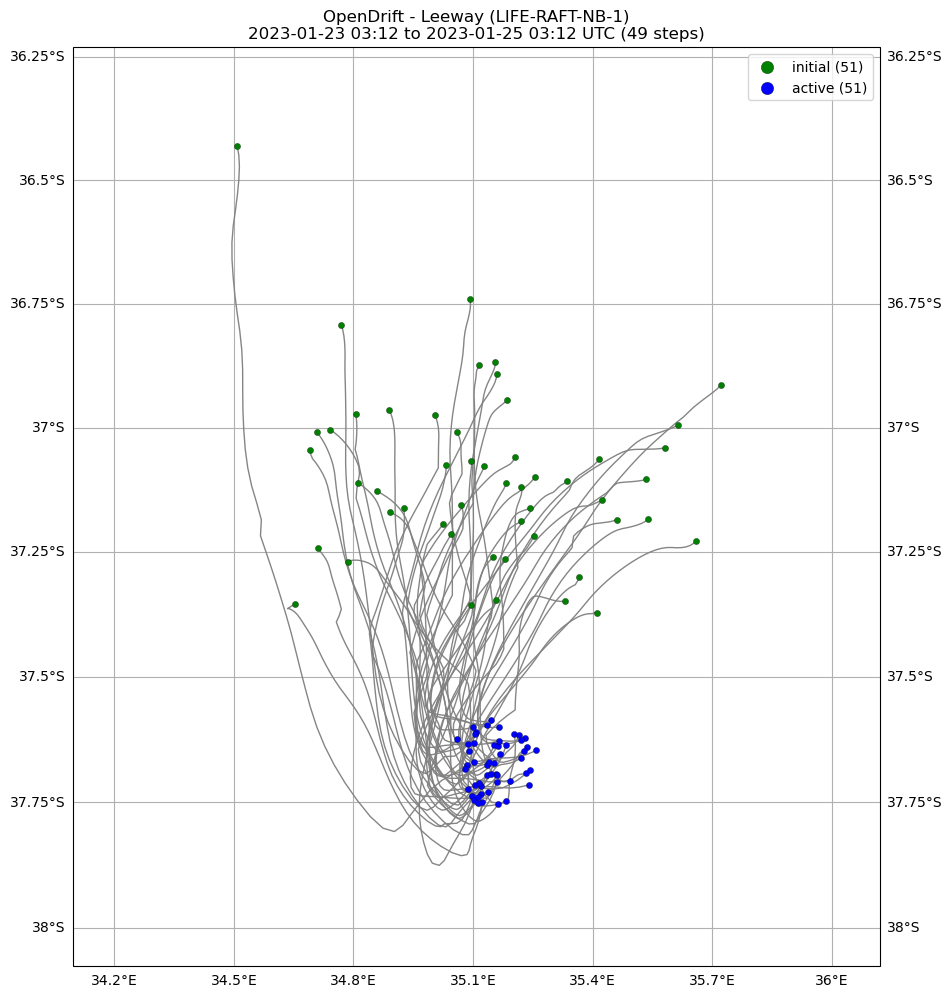

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-01-23 03:12 to 2023-01-25 03:12 UTC (49 steps)'}>,
 <Figure size 962.738x1100 with 1 Axes>)

In [77]:
o_hit.plot()

12:43:27 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=True, lscale=None
12:43:27 WARNING opendrift.models.basemodel:2379: Plotting fast. This will make your plots less accurate.


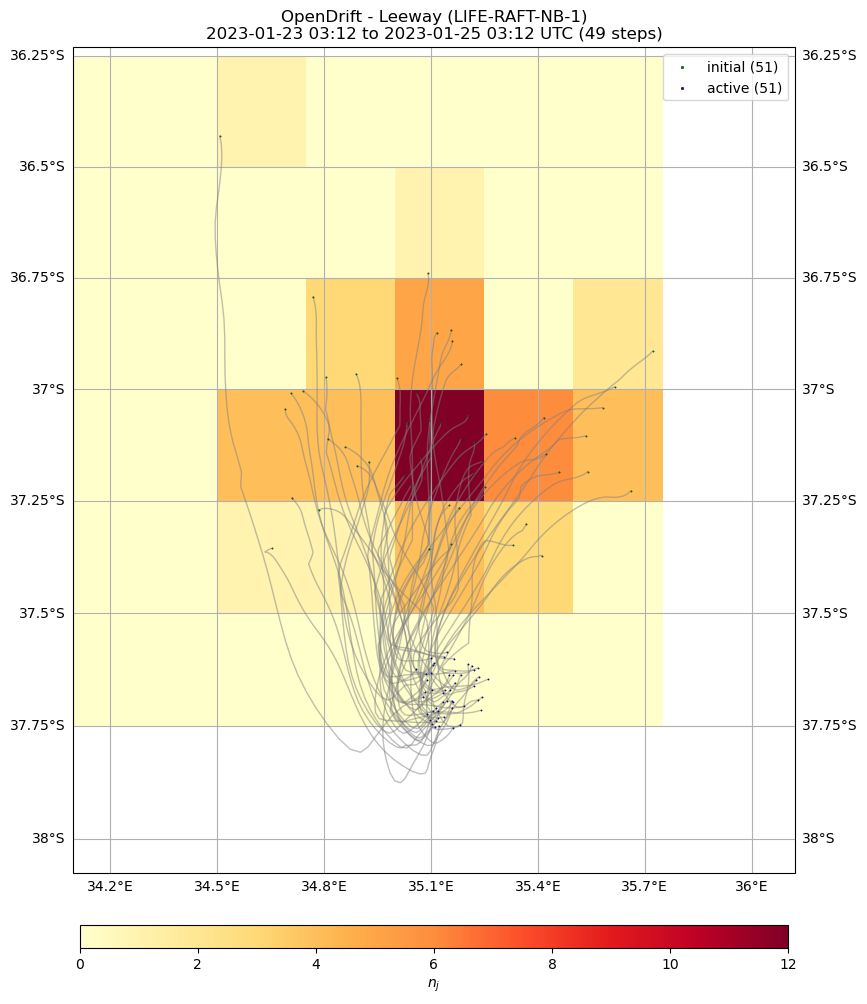

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-01-23 03:12 to 2023-01-25 03:12 UTC (49 steps)'}>,
 <Figure size 962.738x1100 with 2 Axes>)

In [92]:
o_hit.plot(background=grid_counts, clabel='$n_j$', fast=True, markersize=1, lalpha=.5, cmap='YlOrRd')

In [52]:
outfile_bwd_truth = "D:/backtrack/oceandrift_48h/likelihood/lw_bwd_2325jan_raft_capsize_truth_v3.nc"

In [53]:
orev1 = Leeway(loglevel=50)

12:33:17 DEBUG   opendrift.config:161: Adding 10 config items from environment
12:33:17 DEBUG   opendrift.config:161: Adding 5 config items from environment


In [54]:
orev1 = Leeway(loglevel=50)
orev1.add_reader([reader_globcur, reader_wind])

orev1.set_config('drift:advection_scheme', 'runge-kutta4')
orev1.set_config('environment:fallback:x_sea_water_velocity', 0)
orev1.set_config('environment:fallback:y_sea_water_velocity', 0)

orev1.set_config('capsizing', True)
orev1.set_config('capsizing:wind_threshold', 20)
orev1.set_config('capsizing:wind_threshold_sigma', 5)
orev1.set_config('capsizing:leeway_fraction', 0.4)  # Reducing leeway coefficients to 40% of original after capsize

#orev.set_config('drift:horizontal_diffusivity', 20)
orev1.seed_elements(lon=ilon, lat=ilat, radius=10000, radius_type='uniform', number=len(hits.values[0]), time=end_time, object_type=object_type, capsized=1)
orev1.run(duration=duration, time_step=-600, time_step_output=3600, outfile=outfile_bwd_truth)

In [55]:
bwd_truth = xr.open_dataset(outfile_bwd_truth)

In [56]:
capsized_bwd_truth = []
for i in range(len(bwd_truth.trajectory)):
    capsized_bwd_truth.append(bwd_truth.isel(trajectory=i).capsized.values[-1])

In [57]:
np.count_nonzero(capsized_bwd_truth)

15

In [58]:
len(bwd_truth.trajectory)

51

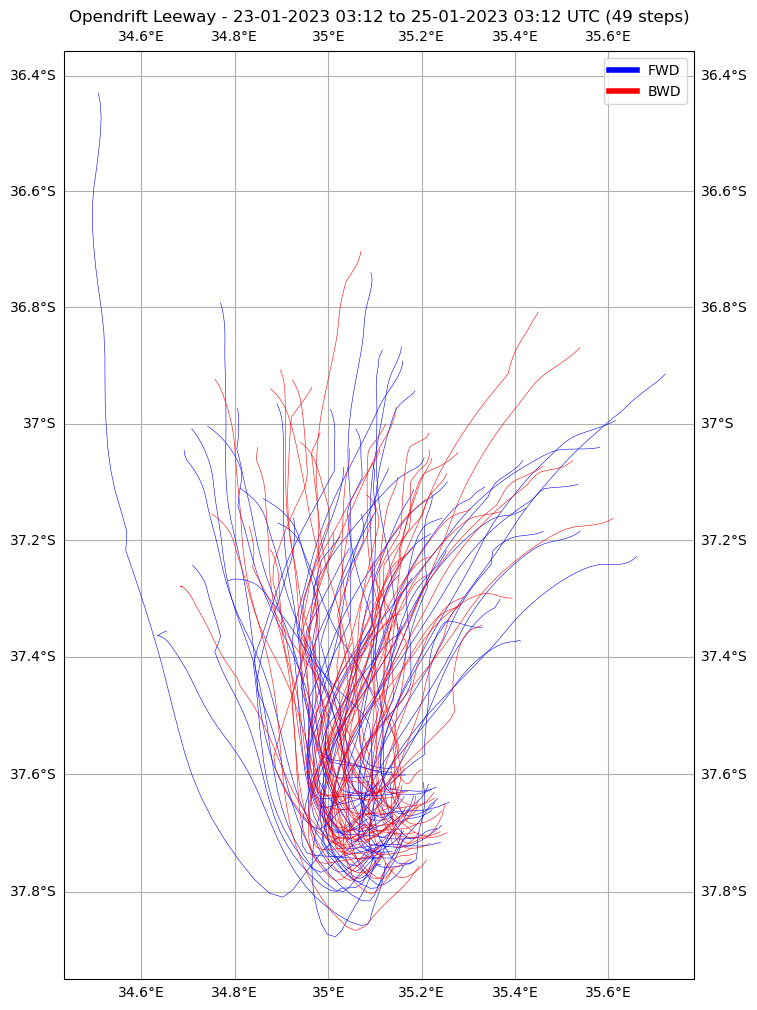

In [59]:
### PLOT ### 
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(xfwd.trajectory)):
    xfwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')

for i in range(len(bwd_truth.trajectory)):
    bwd_truth.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
    
ccrs.Geodetic()

custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                #Line2D([0], [0], color='grey', lw=4),
                #Line2D([0], [0], color='black', lw=4)
               ]

ax.legend(custom_lines, ['FWD', 'BWD'])

plt.gca().autoscale()
plt.title('Opendrift Leeway - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
plt.show()

In [79]:
lonback = []       # lon for bwd
latback = []       # lat for bwd

for i in range(len(bwd_truth.trajectory)):
    lonback.append(bwd_truth.isel(trajectory=i).lon.values[-1])
    latback.append(bwd_truth.isel(trajectory=i).lat.values[-1])

In [102]:
### EXTENDED GRID ###

# Set the desired grid size
xgrid_size_lon = 0.25  # Change this to your desired grid size
xgrid_size_lat = 0.25

# Calculate the number of grid cells in each dimension
xlon_bins = np.arange(34, 36.25, xgrid_size_lon)
xlat_bins = np.arange(-37.75, -36, xgrid_size_lat)

In [104]:
grid_counts_back = count_points_in_grid(lonback, latback, xlon_bins, xlat_bins)

In [105]:
o_back = opendrift.open(outfile_bwd_truth)

12:45:19 DEBUG   opendrift.config:161: Adding 10 config items from environment
12:45:19 DEBUG   opendrift.config:161: Adding 5 config items from environment
12:45:19 DEBUG   opendrift.config:161: Adding 16 config items from __init__
12:45:19 DEBUG   opendrift.config:171:   Overwriting config item readers:max_number_of_fails
12:45:19 DEBUG   opendrift.config:161: Adding 5 config items from __init__
12:45:19 INFO    opendrift.models.basemodel:533: OpenDriftSimulation initialised (version 1.11.2 / v1.11.2-43-gce9f6bb)
12:45:19 DEBUG   opendrift.config:161: Adding 6 config items from leeway
12:45:19 DEBUG   opendrift.config:171:   Overwriting config item seed:jibe_probability
12:45:19 DEBUG   opendrift.export.io_netcdf:281: Importing from D:/backtrack/oceandrift_48h/likelihood/lw_bwd_2325jan_raft_capsize_truth_v3.nc
12:45:19 DEBUG   opendrift.models.basemodel:1683: No elements to deactivate
12:45:19 DEBUG   opendrift.export.io_netcdf:380: Setting imported config: environment:constant:x_win

12:45:19 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=True, lscale=None
12:45:19 WARNING opendrift.models.basemodel:2379: Plotting fast. This will make your plots less accurate.


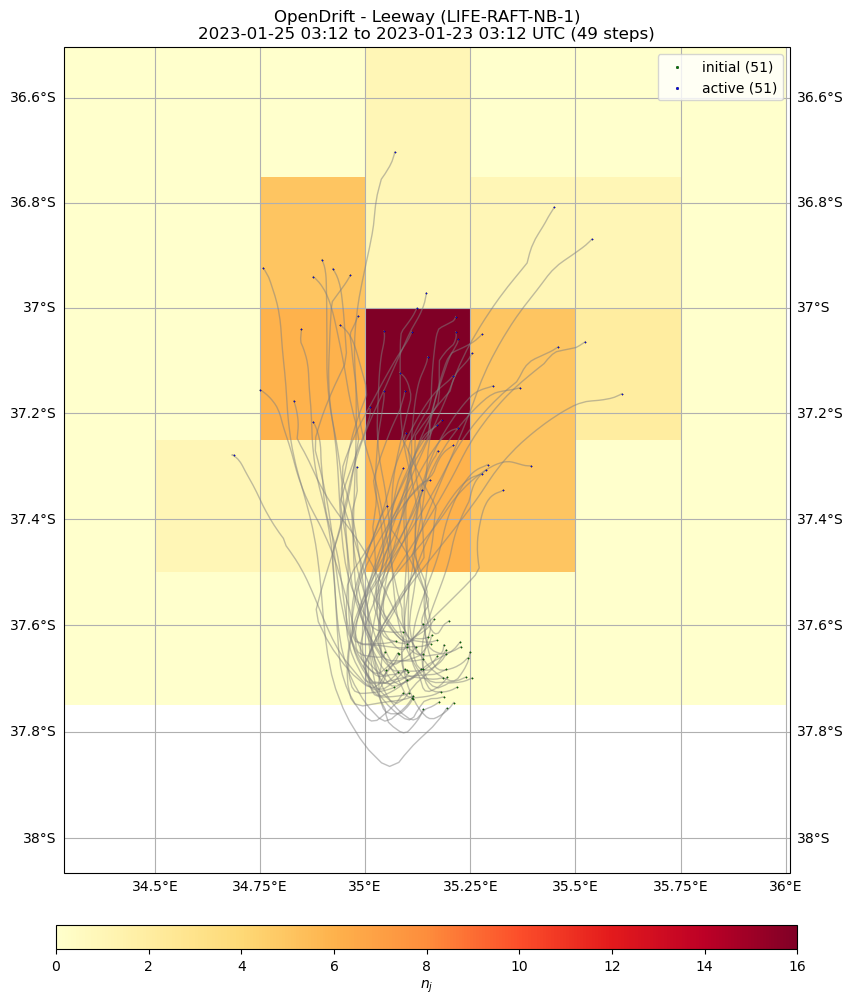

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-01-25 03:12 to 2023-01-23 03:12 UTC (49 steps)'}>,
 <Figure size 967.304x1100 with 2 Axes>)

In [106]:
o_back.plot(background=grid_counts_back, clabel='$n_j$', fast=True, markersize=1, lalpha=.5, vmin=0, cmap='YlOrRd')

In [107]:
grid_counts_back-grid_counts

<xarray.DataArray (lon_bin: 8, lat_bin: 6)> Size: 384B
array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -4.,  0.,  0., -1.],
       [ 0.,  0.,  2.,  2.,  0.,  0.],
       [ 0.,  2.,  4., -4.,  0.,  0.],
       [ 0.,  2., -1.,  1.,  0.,  0.],
       [ 0.,  0., -2., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])
Coordinates:
  * lon_bin  (lon_bin) float64 64B 34.12 34.38 34.62 34.88 ... 35.38 35.62 35.88
  * lat_bin  (lat_bin) float64 48B -37.62 -37.38 -37.12 -36.88 -36.62 -36.38

12:45:23 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=True, lscale=None
12:45:23 WARNING opendrift.models.basemodel:2379: Plotting fast. This will make your plots less accurate.


<Figure size 640x480 with 0 Axes>

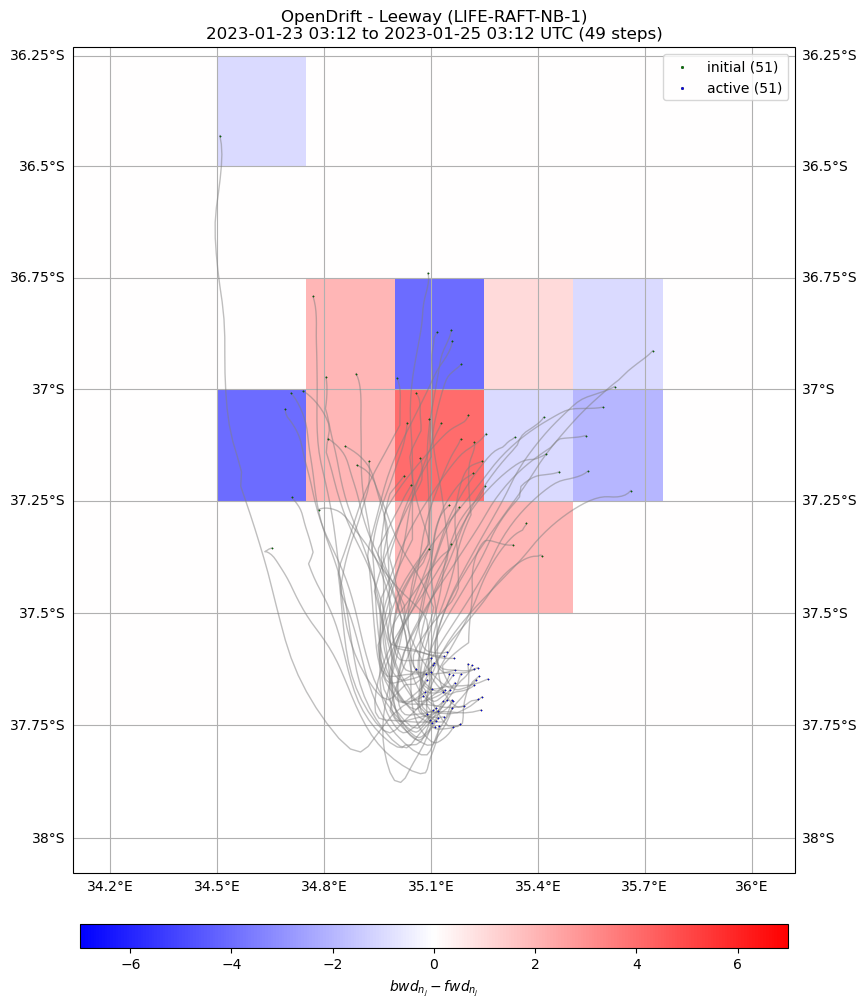

<Figure size 640x480 with 0 Axes>

In [108]:
plt.figure()

o_hit.plot(background=grid_counts_back-grid_counts, clabel='$bwd_{n_j} - fwd_{n_j}$', cmap='bwr', fast=True, markersize=1, lalpha=.5, vmin=-7, vmax=7)

plt.savefig('dif.png') 

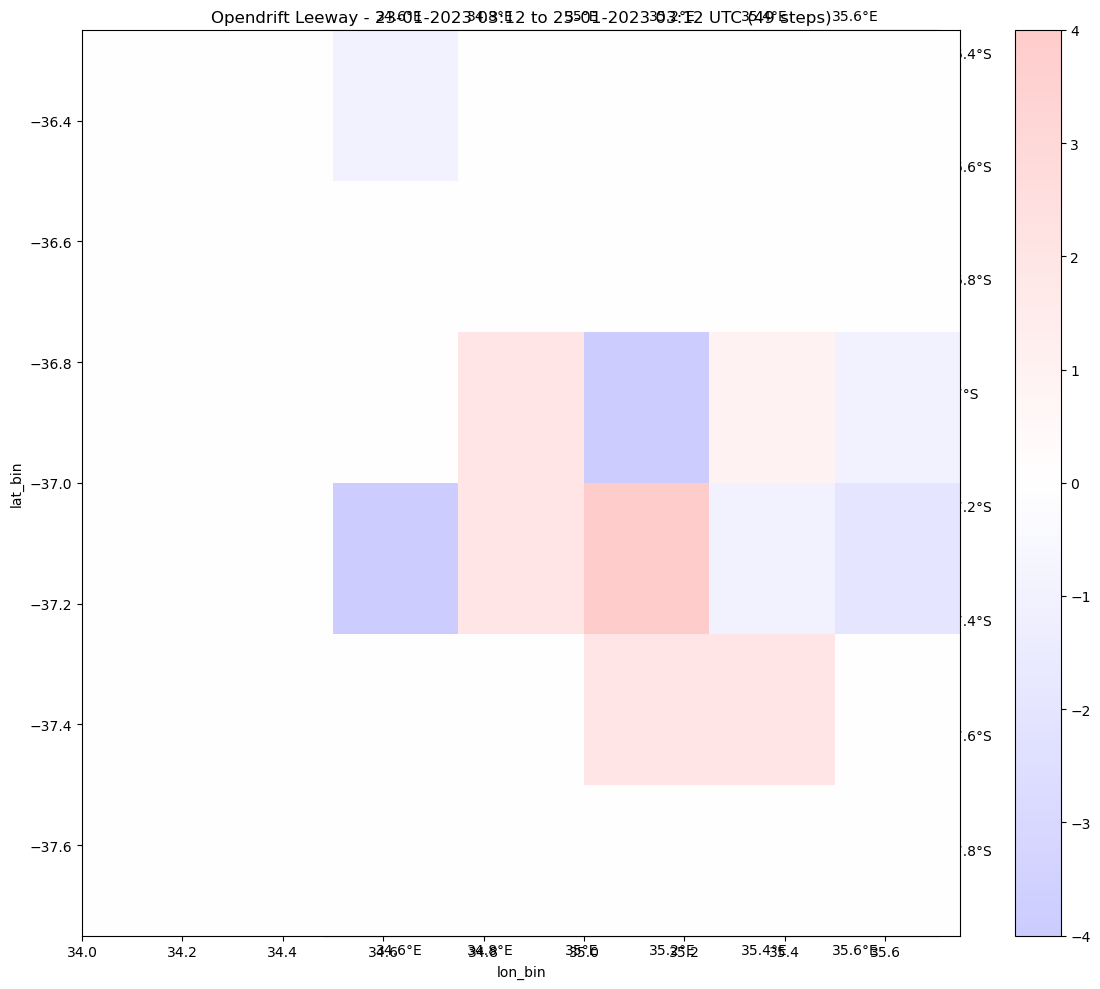

In [109]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(xfwd.trajectory)):
    xfwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')

for i in range(len(bwd_truth.trajectory)):
    bwd_truth.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')


ax1 = fig.add_subplot()
dif.plot(x=grid_counts_back.dims[0], y=grid_counts_back.dims[1],cmap='bwr', alpha=.2)

ccrs.Geodetic()

custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                #Line2D([0], [0], color='grey', lw=4),
                #Line2D([0], [0], color='black', lw=4)
               ]

ax.legend(custom_lines, ['FWD', 'BWD'])

plt.gca().autoscale()
plt.title('Opendrift Leeway - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
plt.show()

In [110]:
dif = grid_counts_back-grid_counts

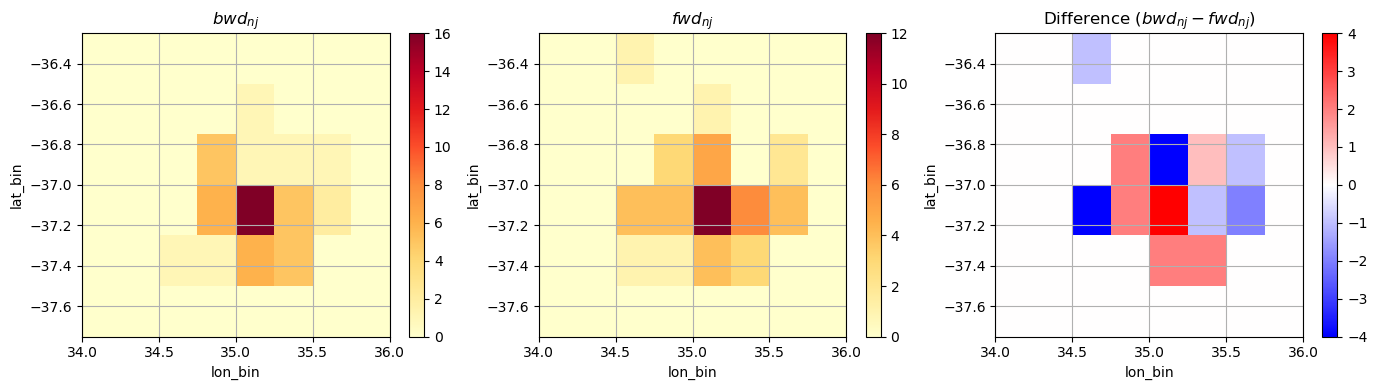

In [111]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
grid_counts_back.plot(x=grid_counts_back.dims[0], y=grid_counts_back.dims[1], cmap='YlOrRd')
plt.title('$bwd_{nj}$')
plt.grid()

plt.subplot(1,3,2)
grid_counts.plot(x=grid_counts.dims[0], y=grid_counts.dims[1], cmap='YlOrRd')
plt.title('$fwd_{nj}$')
plt.grid()

plt.subplot(1,3,3)
dif.plot(x=grid_counts_back.dims[0], y=grid_counts_back.dims[1], cmap='bwr')
plt.title('Difference $(bwd_{nj}-fwd_{nj})$')
plt.grid()

plt.savefig('drieluik.png') 

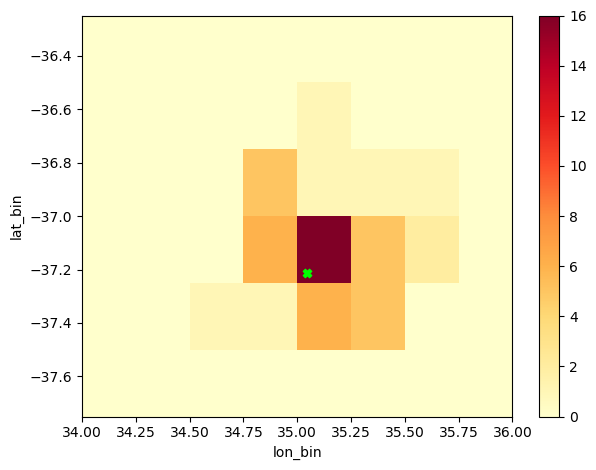

In [131]:
grid_counts_back.plot(x=grid_counts_back.dims[0], y=grid_counts_back.dims[1], cmap='YlOrRd')
plt.scatter(fwd.isel(trajectory=a).isel(time=0).lon.values, fwd.isel(trajectory=a).isel(time=0).lat.values, marker='X', color='lime')

In [122]:
fwd.isel(trajectory=a).isel(time=0).lon.values

array(35.044914, dtype=float32)

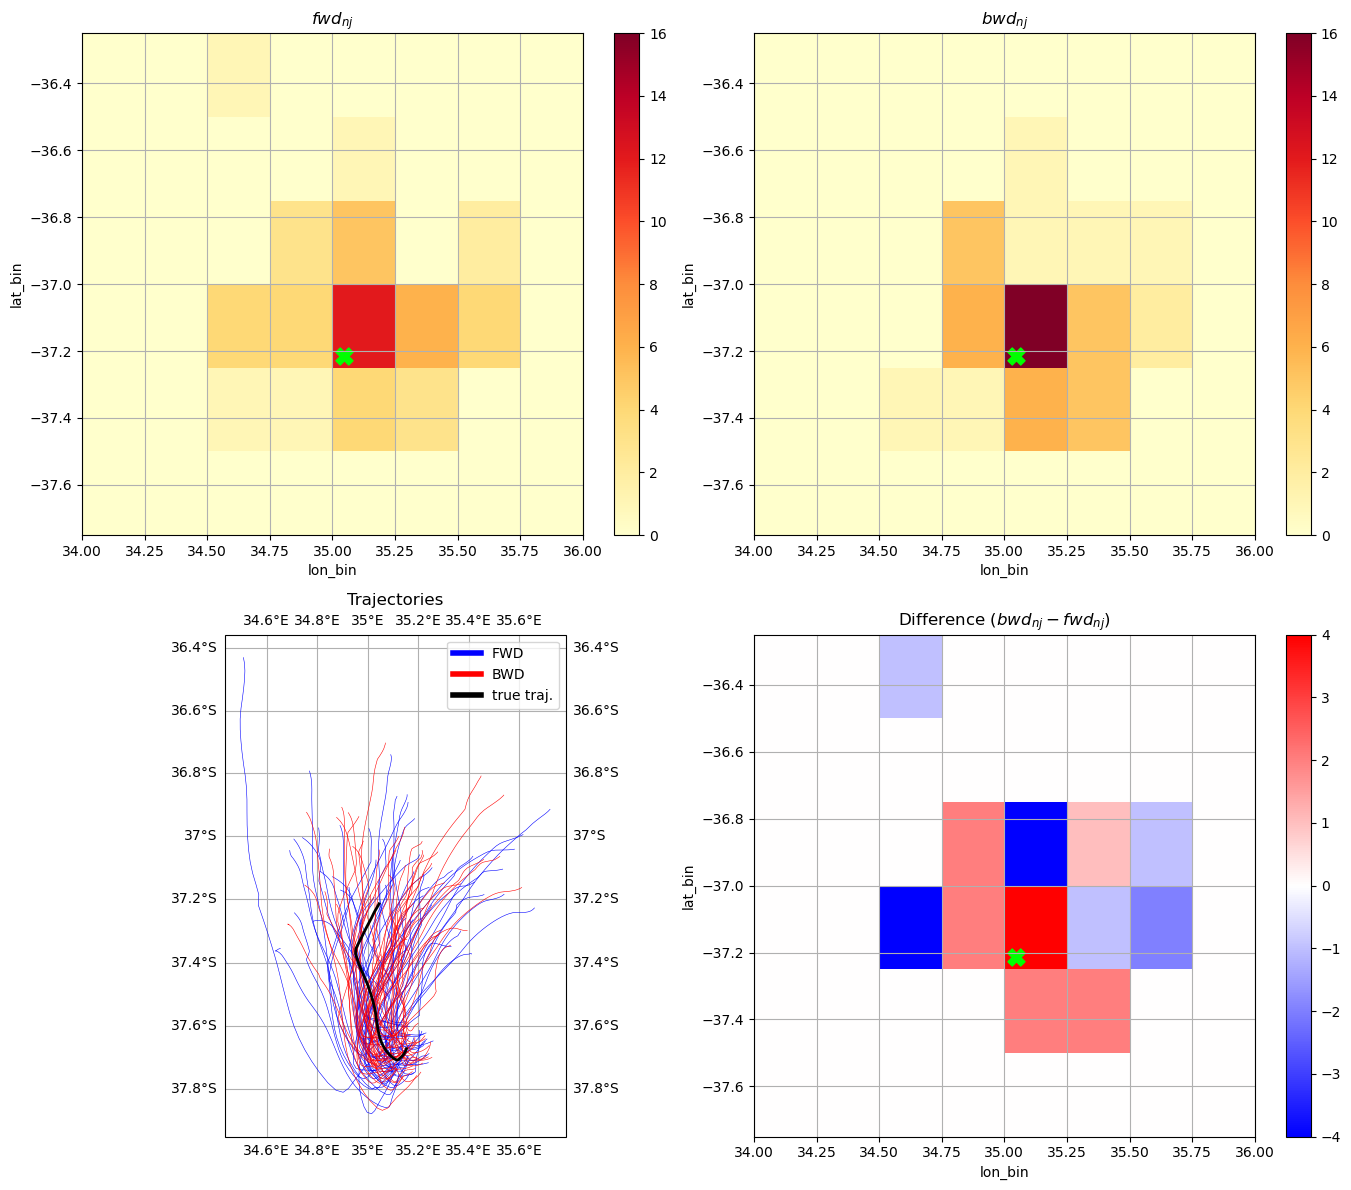

In [172]:
fig = plt.figure(figsize=(14,12))
size=150

plt.subplot(2,2,2)
grid_counts_back.plot(x=grid_counts_back.dims[0], y=grid_counts_back.dims[1], cmap='YlOrRd')
plt.scatter(fwd.isel(trajectory=a).isel(time=0).lon.values, fwd.isel(trajectory=a).isel(time=0).lat.values, size, marker='X', color='lime')
plt.title('$bwd_{nj}$')
plt.grid()

plt.subplot(2,2,1)
grid_counts.plot(x=grid_counts.dims[0], y=grid_counts.dims[1], vmax=16, cmap='YlOrRd')
plt.scatter(fwd.isel(trajectory=a).isel(time=0).lon.values, fwd.isel(trajectory=a).isel(time=0).lat.values, size, marker='X', color='lime')
plt.title('$fwd_{nj}$')
plt.grid()

plt.subplot(2,2,4)
dif.plot(x=grid_counts_back.dims[0], y=grid_counts_back.dims[1], cmap='bwr')
plt.scatter(fwd.isel(trajectory=a).isel(time=0).lon.values, fwd.isel(trajectory=a).isel(time=0).lat.values, size, marker='X', color='lime')
plt.title('Difference $(bwd_{nj}-fwd_{nj})$')
plt.grid()

# plt.subplot(2,2,3)
ax = fig.add_subplot(223, projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(xfwd.trajectory)):
    xfwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')
    # if capsized_xfwd[i]<1:
    #     xfwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')
    # else: 
    #     xfwd.isel(trajectory=i).traj.plot(linewidth=1, linestyle='--', color='blue')

for i in range(len(bwd_truth.trajectory)):
    bwd_truth.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
    # if capsized_bwd_truth[i]>0: 
    #     bwd_truth.isel(trajectory=i).traj.plot(linewidth=1, linestyle='--', color='red')
    # else: 
    #     bwd_truth.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
        
fwd.isel(trajectory=a).traj.plot(color='black', linewidth=2)

custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                #Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4)
               ]

ax.legend(custom_lines, ['FWD', 'BWD', 'true traj.'])

# plt.gca().autoscale()
plt.title('Trajectories')

plt.savefig('vierluik_2325jan.png') 
plt.show()

No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimen

IndexError: index 120 is out of bounds for axis 0 with size 49

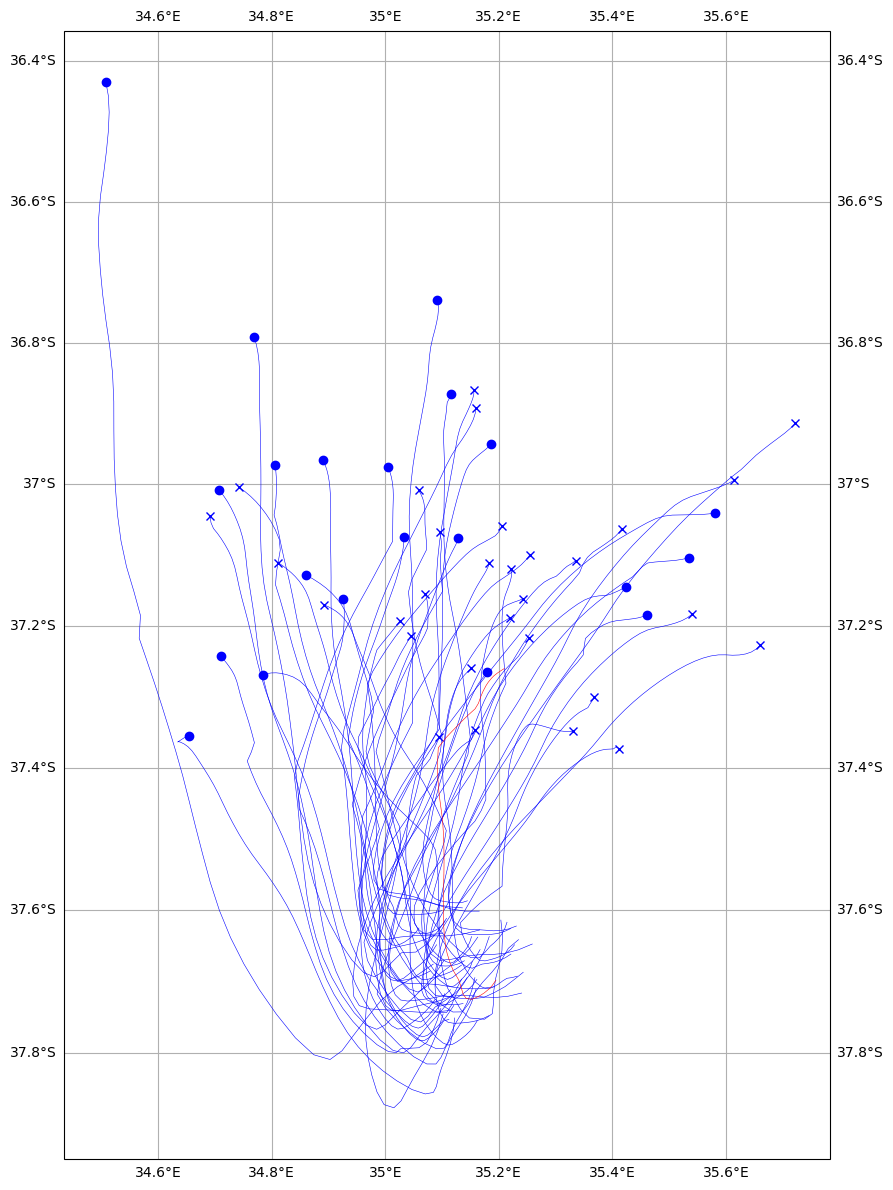

In [143]:
fig = plt.figure(figsize=(14,12))

ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(xfwd.trajectory)):
    xfwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')
    if capsized_xfwd[i]<1:
        xfwd.isel(trajectory=i).isel(time=0).traj.plot(marker='o', color='blue')
    else: 
        xfwd.isel(trajectory=i).isel(time=0).traj.plot(marker='x', color='blue')

for i in range(len(bwd_truth.trajectory)):
    bwd_truth.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
    if capsized_bwd_truth[i]>0: 
        bwd_truth.isel(trajectory=i).isel(time=120).traj.plot(marker='x', color='red')
    else: 
        bwd_truth.isel(trajectory=i).isel(time=120).traj.plot(marker='o', color='red')
        
custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                #Line2D([0], [0], color='grey', lw=4),
                #Line2D([0], [0], color='black', lw=4)
               ]

ax.legend(custom_lines, ['FWD', 'BWD'])

# plt.gca().autoscale()
plt.title('Trajectories')
plt.show()

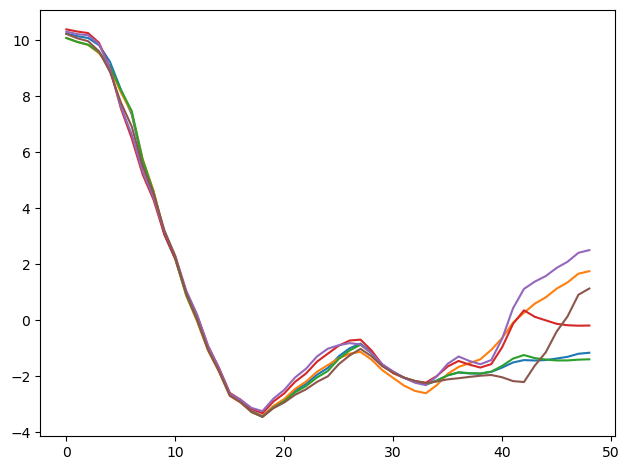

In [144]:
plt.plot(bwd_truth.isel(trajectory=0).x_wind)
plt.plot(bwd_truth.isel(trajectory=5).x_wind)
plt.plot(bwd_truth.isel(trajectory=10).x_wind)
plt.plot(bwd_truth.isel(trajectory=15).x_wind)
plt.plot(bwd_truth.isel(trajectory=20).x_wind)
plt.plot(bwd_truth.isel(trajectory=25).x_wind)

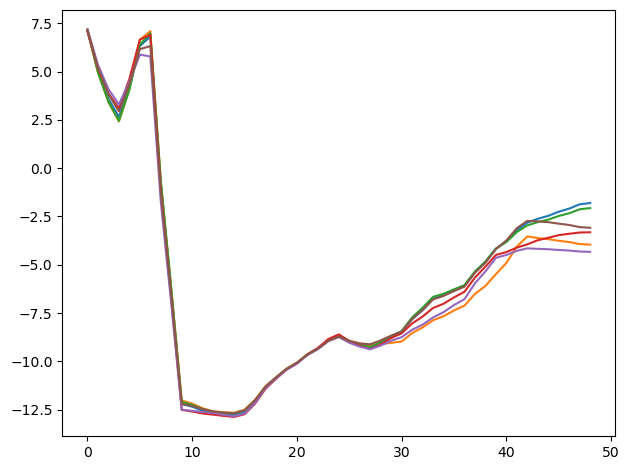

In [145]:
plt.plot(bwd_truth.isel(trajectory=0).y_wind)
plt.plot(bwd_truth.isel(trajectory=5).y_wind)
plt.plot(bwd_truth.isel(trajectory=10).y_wind)
plt.plot(bwd_truth.isel(trajectory=15).y_wind)
plt.plot(bwd_truth.isel(trajectory=20).y_wind)
plt.plot(bwd_truth.isel(trajectory=25).y_wind)

In [170]:
wind = np.sqrt(np.square(xfwd.isel(trajectory=10).x_wind.values)+np.square(xfwd.isel(trajectory=10).y_wind.values))

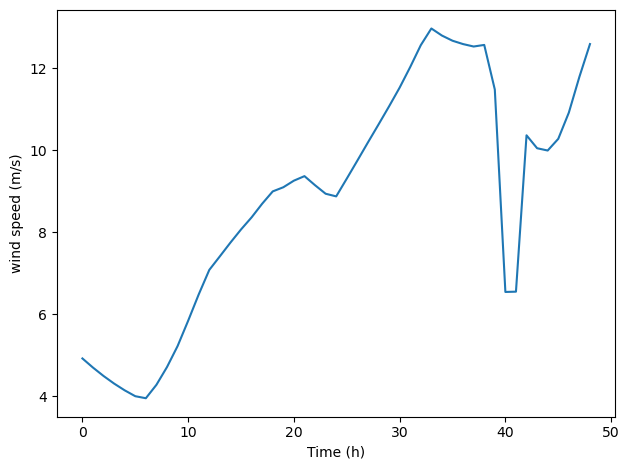

In [173]:
plt.plot(wind)
plt.xlabel('Time (h)')
plt.ylabel('wind speed (m/s)')

plt.savefig('wind_2325jan.png') 

In [164]:
bwd_truth.isel(trajectory=0).x_wind.values

array([10.232763  , 10.142227  , 10.076354  ,  9.819761  ,  9.227661  ,
        8.239057  ,  7.35178   ,  5.619408  ,  4.4946737 ,  3.0533414 ,
        2.1734352 ,  0.930998  ,  0.05657889, -0.98804826, -1.7329173 ,
       -2.6010718 , -2.865442  , -3.2356253 , -3.416328  , -3.0726037 ,
       -2.8323345 , -2.501595  , -2.267815  , -1.9422321 , -1.6990004 ,
       -1.2824032 , -0.9964201 , -0.8283414 , -1.1494832 , -1.5794106 ,
       -1.8499682 , -2.0545883 , -2.200138  , -2.2949784 , -2.1498804 ,
       -1.9630208 , -1.8626118 , -1.8947892 , -1.9014709 , -1.8386722 ,
       -1.6843562 , -1.503048  , -1.4180653 , -1.433788  , -1.4173876 ,
       -1.3617465 , -1.3012443 , -1.1921602 , -1.1565442 ], dtype=float32)